# pc

> Point Cloud data manipulation

In [ ]:
#| default_exp pc

In [ ]:
#| hide
from nbdev.showdoc import *

Two kind of indices are supported.
One is called `grid index` or `gix`. 
`gix` is expressed as sorted `int32` array with shape `(2, n_point)`.
`gix[0,:]` is their azimuth indices and `gix[1,:]` is the range indices.
`gix` is first sorted in azimuth indices and then sorted in range indices.
Here is an example:
```
array([[0, 0, 1, 1, 2, 3],
       [2, 3, 0, 3, 1, 2]], dtype=int32)
```
The advantage of `gix` is that it is directly connected to the original raster indices.
While the disadvantage is it does not maintain locality,
i.e., two points that are geographical close to each other
may not be close to each other in the storage
which makes data query (e.g., find all points that within a bounding box) inefficient.

To solve that, another kind indices called `hillbert index` or `hix`
is introduced.
`hix` is expressed as sorted `int64` array with shape `(n_point,)`.
Note that `hix` is calculated by the geographical coordiantes of point cloud data,
i.e., lonitude and latitude, or coordinates in other projection (e.g., WebMercator),
and a predifined grid (i.e., x_start, x_stop, x_step, y_start, y_stop, y_step).

::: {.callout-warning}
`hix` of two point cloud datasets calculated with different grids are not compatitable.
:::

::: {.callout-warning}
Only the input `idx` of `pc_sort` can be unsorted indices, `idx` in other functions have to be sorted. 
:::

Please see [pc_hix](#pc_hix) for how to generate `hix`.

In [ ]:
#| export
import numpy as np
from numba import prange
import math
try:
    import cupy as cp
    from cupy._sorting.search import _exists_kernel
except:
    pass
from moraine.utils_ import ngjit, ngpjit
from moraine.coord_ import Coord

In [ ]:
#| code-fold: true
#| code-summary: "For generating data for doc and test"
import numpy as np
try:
    import cupy as cp
except:
    pass
from matplotlib import pyplot as plt

In [ ]:
#| export
def pc2ras(gix:np.ndarray|cp.ndarray, # gix array
           pc_data:np.ndarray|cp.ndarray, # data, 1D or more
           shape:tuple, # image shape
          ):
    '''convert point cloud data to original raster, filled with nan'''
    xp = cp.get_array_module(pc_data)
    raster = xp.empty((*shape,*pc_data.shape[1:]),dtype=pc_data.dtype)
    raster[:] = xp.nan
    raster[gix[0],gix[1]] = pc_data
    return raster

In [ ]:
#| hide
a = np.arange(1000,dtype=np.float32).reshape(50,20)
gix = np.arange(100).reshape(2,-1)
a_raster = pc2ras(gix,a,shape=(100,100))
np.testing.assert_array_equal(a_raster[gix[0],gix[1]],a)

In [ ]:
#| export
def _ras_dims(gix1:np.ndarray|cp.ndarray, # int array, grid index of the first point cloud
              gix2:np.ndarray|cp.ndarray=None, # int array, grid index of the second point cloud
             )->tuple: # the shape of the original raster image
    '''Get the shape of the original raster image from two index, the shape could be smaller than the truth but it doesn't matter.'''
    xp = cp.get_array_module(gix1)
    if gix2 is None:
        dims_az = gix1[0,-1]+1
        dims_r = int(xp.max(gix1[1,:]))+1
    else:
        dims_az = max(int(gix1[0,-1]),int(gix2[0,-1]))+1
        dims_r = max(int(xp.max(gix1[1,:])),int(xp.max(gix2[1,:])))+1
    return (dims_az,dims_r)

In [ ]:
#| export
# Some functions adapted from spatialpandas at https://github.com/holoviz/spatialpandas under BSD-2-Clause license,
# Which is Initially based on https://github.com/galtay/hilbert_curve, but specialized
# for 2 dimensions with numba acceleration

# Further enhanced with numba prange.
@ngjit
def _int_2_binary(v, width): # Return a binary byte array representation of `v` zero padded to `width` bits.
    res = np.zeros(width, dtype=np.uint8)
    for i in range(width):
        res[width - i - 1] = v % 2
        v = v >> 1
    return res
@ngjit
def _binary_2_int(bin_vec):
    # Convert a binary byte array to an integer
    res = 0
    next_val = 1
    width = len(bin_vec)
    for i in range(width):
        res += next_val*bin_vec[width - i - 1]
        next_val <<= 1
    return res
@ngjit
def _hilbert_integer_to_transpose(p:int, # iterations to use in the hilbert curve
                                  h:int, # integer distance along hilbert curve
                                 )->list: # x (list): transpose of h (n components with values between 0 and 2**p-1)
    #Store a hilbert integer (`h`) as its transpose (`x`).
    h_bits = _int_2_binary(h, 2*p)

    x = [_binary_2_int(h_bits[i::2]) for i in range(2)]
    return x
@ngjit
def _transpose_to_hilbert_integer(p:int, # iterations to use in the hilbert curve
                                  coord:list, # transpose of h (2 components with values between 0 and 2**p-1)
                                 )->int: # h (int): integer distance along hilbert curve
    # Restore a hilbert integer (`h`) from its transpose (`x`).
    bins = [_int_2_binary(v, p) for v in coord]
    concat = np.zeros(2*p, dtype=np.uint8)
    for i in range(p):
        for j in range(2):
            concat[2*i + j] = bins[j][i]

    h = _binary_2_int(concat)
    return h

@ngjit
def _coordinate_from_distance(p:int, # iterations to use in the hilbert curve
                              h:int, # integer distance along hilbert curve
                             )->list: # coord (list): Coordinate as length-n list
    # Return the coordinate for a hilbert distance.
    coord = _hilbert_integer_to_transpose(p, h)
    Z = 2 << (p-1)

    # Gray decode by H ^ (H/2)
    t = coord[1] >> 1
    for i in range(1, 0, -1):
        coord[i] ^= coord[i-1]
    coord[0] ^= t

    # Undo excess work
    Q = 2
    while Q != Z:
        P = Q - 1
        for i in range(1, -1, -1):
            if coord[i] & Q:
                # invert
                coord[0] ^= P
            else:
                # exchange
                t = (coord[0] ^ coord[i]) & P
                coord[0] ^= t
                coord[i] ^= t
        Q <<= 1

    return coord
@ngjit
def _distance_from_coordinate(p:int, # iterations to use in the hilbert curve
                              coord:np.ndarray, # coordinate as 1d array
                             )->int: # distance
    # Return the hilbert distance for a given coordinate.
    M = 1 << (p - 1)
    # Inverse undo excess work
    Q = M
    while Q > 1:
        P = Q - 1
        for i in range(2):
            if coord[i] & Q:
                coord[0] ^= P
            else:
                t = (coord[0] ^ coord[i]) & P
                coord[0] ^= t
                coord[i] ^= t
        Q >>= 1
    # Gray encode
    for i in range(1, 2):
        coord[i] ^= coord[i - 1]
    t = 0
    Q = M
    while Q > 1:
        if coord[1] & Q:
            t ^= Q - 1
        Q >>= 1
    for i in range(2):
        coord[i] ^= t
    h = _transpose_to_hilbert_integer(p, coord)
    return h
@ngpjit
def _coordinates_from_distances(p:int, # iterations to use in the hilbert curve
                                h:np.ndarray, # 1d array of integer distances along hilbert curve
                               )->np.ndarray: # 2d array of coordinate, each row a coordinate corresponding to associated distance value in input.
    # Return the coordinates for an array of hilbert distances.
    result = np.zeros(2, (len(h)), dtype=np.int64)
    for i in prange(len(h)):
        result[:, i] = _coordinate_from_distance(p, h[i])
    return result
@ngpjit
def _distances_from_coordinates(p:int, # iterations to use in the hilbert curve
                                coords:np.ndarray, # 2d array of coordinates, one coordinate per row
                               )->np.ndarray: # 1d array of distances
    # Return the hilbert distances for a given set of coordinates.
    coords = np.atleast_2d(coords).copy()
    result = np.zeros(coords.shape[1], dtype=np.int64)
    for i in prange(coords.shape[1]):
        coord = coords[:, i]
        result[i] = _distance_from_coordinate(p, coord)
    return result

In [ ]:
#| export
def pc_hix(x:np.ndarray, # horizonal coordinate
           y:np.ndarray, # vertical coordinate
           bbox:list, # [x0, y0, xm, ym]
           interval:list # [x_interval, y_interval], cell size to make every cell has only one point falled in.
          )->np.ndarray:
    '''Compute the hillbert index for point cloud data.'''
    x0, y0, xm, ym = bbox
    dx, dy = interval
    nx = math.ceil((xm-x0)/dx)
    ny = math.ceil((ym-y0)/dy)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    gix = coord.coords2gixs([y,x])
    hix = _distances_from_coordinates(coord.p,gix)
    assert len(np.unique(hix)) == len(hix), "`hix` includes duplicated element. Probably `bbox` is too small or `interval` is too big." 
    return hix

usage:

In [ ]:
x = np.random.rand(1000)
y = np.random.rand(1000)
bbox = [0,0,1,1]

In [ ]:
hix = pc_hix(x, y, bbox, interval=[0.001,0.001])

<matplotlib.colorbar.Colorbar>

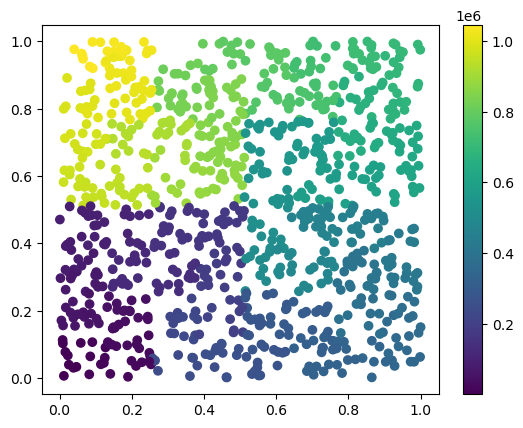

In [ ]:
plt.scatter(x, y, c=hix)
plt.colorbar()

Hillbert index have a very useful locality property:

- Points with hillbert indexes close to an index will be geometrically close to the point corresponding to that index.

This enable fast data query of billions of points.
See [rtree](./rtree.ipynb) for data query.

In [ ]:
#| export
def pc_sort(idx:np.ndarray|cp.ndarray, # unsorted `gix` (2D) or `hix`(1D)
           )->np.ndarray|cp.ndarray: # indices that sort input
    '''Get the indices that sort the input.'''
    xp = cp.get_array_module(idx)
    if idx.ndim == 2:
        dims_az = int(xp.max(idx[0,:]))+1
        dims_r = int(xp.max(idx[1,:]))+1
        idx_1d = xp.ravel_multi_index(idx,dims=(dims_az,dims_r))
    else:
        idx_1d = idx
    key = xp.argsort(idx_1d,kind='stable')
    return key

::: {.callout-warning}
Only the input `idx` of `pc_sort` can be unsorted indices, `idx` in other functions have to be sorted. 
:::

In [ ]:
gix = np.array([[0,1,5,3,4,3],
                [3,5,2,4,6,8]])
key = pc_sort(gix)
np.testing.assert_equal(gix[:,key],np.array([[0,1,3,3,4,5],
                                             [3,5,4,8,6,2]]))

In [ ]:
hix = np.array([0,1,5,4,3])
key = pc_sort(hix)
np.testing.assert_equal(hix[key],np.array([0,1,3,4,5]))

In [ ]:
#| export
def pc_union(idx1:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the first point cloud
             idx2:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the second point cloud
             # the union index `idx`; index of the point in output union index that originally in the first point cloud `inv_iidx`;
             # index of the point in output union index that only exist in the second point cloud `inv_iidx2`;
             # index of the point in the second input index that are not in the first input point cloud
            )->tuple: 
    '''Get the union of two point cloud dataset. For points at their intersection, pc_data1 rather than pc_data2 is copied to the result pc_data.'''
    # this function is modified from np.unique

    xp = cp.get_array_module(idx1)
    n1 = idx1.shape[-1]; n2 = idx2.shape[-1]
    idx = xp.concatenate((idx1,idx2),axis=-1)
    if idx.ndim == 2:
        dims = _ras_dims(idx1,idx2)
        idx_1d = xp.ravel_multi_index(idx,dims=dims) # automatically the returned 1d index is in int64
    else:
        idx_1d = idx
    iidx = xp.argsort(idx_1d,kind='stable') # test shows argsort is faster than lexsort, that is why use ravel and unravel index
    idx_1d = idx_1d[iidx]

    inv_iidx = xp.empty_like(iidx)
    inv_iidx[iidx] = xp.arange(iidx.shape[0]) # idea taken from https://stackoverflow.com/questions/2483696/undo-or-reverse-argsort-python

    mask = xp.empty(idx_1d.shape, dtype=bool)
    mask[:1] = True
    mask[1:] = idx_1d[1:] != idx_1d[:-1]
    
    idx_1d = idx_1d[mask]
    
    _mask = mask[inv_iidx] # the mask in the original cat order
    mask1 = _mask[:n1]
    mask2 = _mask[n1:]
    
    imask = xp.cumsum(mask) - 1
    inv_iidx = xp.empty(mask.shape, dtype=np.int64)
    inv_iidx[iidx] = imask # inverse the mapping
    inv_iidx = inv_iidx[_mask]
    
    if idx.ndim == 2:
        idx = xp.stack(xp.unravel_index(idx_1d,dims)).astype(idx1.dtype)
    else:
        idx = idx_1d

    return idx, inv_iidx[:n1], inv_iidx[n1:], *xp.where(mask2)

Usage:

In [ ]:
ras = cp.array([[4,3,8,3],
                [4,7,2,6],
                [9,0,3,7],
                [1,4,2,6]])
gix1 = cp.array([[0,0,1,1,2,3],
                 [2,3,0,3,1,2]],dtype=np.int32)
gix2 = cp.array([[0,0,1,2,2,3],
                 [0,3,1,1,3,1]],dtype=np.int32)
pc_data1 = cp.array([3,2,5,4,32,2])
pc_data2 = cp.array([3,5,6,2,1,4])

gix, inv_iidx1, inv_iidx2, iidx2 = pc_union(gix1,gix2)

With all the returns in `pc_union`, it is very easy to construct the union data:

In [ ]:
pc_data = cp.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

np.testing.assert_equal(cp.asnumpy(pc_data),np.array([3,3,2,5,6,4,32,1,4,2]))
np.testing.assert_equal(cp.asnumpy(ras[gix[0],gix[1]]),np.array([4,8,3,4,7,6,0,7,4,2]))

For data with `hix`:

In [ ]:
hix1 = cp.array([2,4,6,8,10],dtype=np.int64)
hix2 = cp.array([1,2,3,6,9],dtype=np.int64)
pc_data1 = cp.array([3,2,5,4,32])
pc_data2 = cp.array([3,5,6,2,1])

hix, inv_iidx1, inv_iidx2, iidx2 = pc_union(hix1,hix2)

pc_data = cp.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

np.testing.assert_equal(cp.asnumpy(pc_data),np.array([3,3,6,2,5,4,1,32]))
# np.testing.assert_equal(cp.asnumpy(ras[idx[0],idx[1]]),np.array([4,8,3,4,7,6,0,7,4,2]))

In [ ]:
#| hide
## deprecated, I think return two index is better
def _cp_intersect1d(arr1:cp.ndarray,
                    arr2:cp.ndarray,
):
    '''Copy of the cupy.intersect1d.
    assume unique
    arr1 and arr2 are assumed to be 1d unique array.
    Only return indices of arr1.
    '''
    mask = _exists_kernel(arr1, arr2, arr2.size, False)
    int1d = arr1[mask]
    arr1_indices = cp.flatnonzero(mask)
    return int1d, arr1_indices

In [ ]:
#| hide
## deprecated
start1 = 0; end1 = 14
start2 = 4; end2 = 20
arr1 = cp.arange(start1,end1,dtype=np.int64)
arr2 = cp.arange(start2,end2,dtype=np.int64)
int1d, idx = _cp_intersect1d(arr1,arr2)
np.testing.assert_almost_equal(cp.asnumpy(int1d),np.arange(start2,end1,dtype=np.int64))
np.testing.assert_almost_equal(cp.asnumpy(idx),np.arange(start2-start1,end1-start1,dtype=np.int64))

In [ ]:
#| export
def pc_intersect(idx1:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the first point cloud
                 idx2:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the second point cloud
                 # the intersect index `idx`,
                 # index of the point in first point cloud index that also exist in the second point cloud,
                 # index of the point in second point cloud index that also exist in the first point cloud
                )->tuple:
    '''Get the intersection of two point cloud dataset.'''
    # Here I do not write the core function by myself since cupy have a different implementation of intersect1d

    xp = cp.get_array_module(idx1)
    if idx1.ndim == 2:
        dims = _ras_dims(idx1,idx2)
        idx1_1d = xp.ravel_multi_index(idx1,dims=dims) # automatically the returned 1d index is in int64
        idx2_1d = xp.ravel_multi_index(idx2,dims=dims) # automatically the returned 1d index is in int64
    else:
        idx1_1d = idx1; idx2_1d = idx2

    idx, iidx1, iidx2 = xp.intersect1d(idx1_1d,idx2_1d,assume_unique=True,return_indices=True)
    if idx1.ndim == 2:
        idx = xp.stack(xp.unravel_index(idx,dims)).astype(idx1.dtype)
    return idx, iidx1, iidx2

In [ ]:
ras = cp.array([[4,3,8,3],
                [4,7,2,6],
                [9,0,3,7],
                [1,4,2,6]])
gix1 = cp.array([[0,0,1,1,2,3],
                 [2,3,0,3,1,2]],dtype=np.int32)
gix2 = cp.array([[0,0,1,2,2,3],
                 [0,3,1,1,3,1]],dtype=np.int32)
pc_data1 = cp.array([3,2,5,4,32,2])
pc_data2 = cp.array([3,5,6,2,1,4])

gix, iidx1, iidx2 = pc_intersect(gix1,gix2)
pc_data_int1 = pc_data1[iidx1]
pc_data_int2 = pc_data2[iidx2]

np.testing.assert_equal(cp.asnumpy(gix),np.array([[0,2],
                                                  [3,1]]))
np.testing.assert_equal(cp.asnumpy(ras[(gix[0],gix[1])]),np.array([3,0]))
np.testing.assert_equal(cp.asnumpy(pc_data_int1),np.array([2,32]))
np.testing.assert_equal(cp.asnumpy(pc_data_int2),np.array([5,2]))

In [ ]:
hix1 = cp.array([2,3,4,7,9,14], dtype=np.int64)
hix2 = cp.array([0,3,5,9,11,13],dtype=np.int64)
pc_data1 = cp.array([3,2,5,4,32,2])
pc_data2 = cp.array([3,5,6,2,1,4])

hix, iidx1, iidx2 = pc_intersect(hix1,hix2)
pc_data_int1 = pc_data1[iidx1]
pc_data_int2 = pc_data2[iidx2]

np.testing.assert_equal(cp.asnumpy(hix),np.array([3,9]))
np.testing.assert_equal(cp.asnumpy(pc_data_int1),np.array([2,32]))
np.testing.assert_equal(cp.asnumpy(pc_data_int2),np.array([5,2]))

In [ ]:
#| export
def pc_diff(idx1:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the first point cloud
            idx2:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the second point cloud
            # the diff index `idx`,
            # index of the point in first point cloud index that do not exist in the second point cloud,
           )->tuple:
    '''Get the point cloud in `idx1` that are not in `idx2`.'''
    xp = cp.get_array_module(idx1)
    if idx1.ndim == 2:
        dims = _ras_dims(idx1,idx2)
        idx1_1d = xp.ravel_multi_index(idx1,dims=dims) # automatically the returned 1d index is in int64
        idx2_1d = xp.ravel_multi_index(idx2,dims=dims) # automatically the returned 1d index is in int64
    else:
        idx1_1d = idx1; idx2_1d = idx2
    
    mask = xp.in1d(idx1_1d, idx2_1d, assume_unique=True, invert=True)
    idx = idx1_1d[mask]
    
    if idx1.ndim == 2:
        idx = xp.stack(xp.unravel_index(idx,dims)).astype(idx1.dtype)
        
    return idx, xp.where(mask)[0]

In [ ]:
gix1 = cp.array([[0,0,1,1,2,3],
                 [2,3,0,3,1,2]],dtype=np.int32)
gix2 = cp.array([[0,0,1,2,2,3],
                 [0,3,1,1,3,1]],dtype=np.int32)

gix, iidx1 = pc_diff(gix1,gix2)
pc_data_diff = pc_data1[iidx1]

np.testing.assert_equal(cp.asnumpy(gix),np.array([[0,1,1,3],
                                                  [2,0,3,2]]))
np.testing.assert_equal(cp.asnumpy(iidx1),np.array([0,2,3,5]))

In [ ]:
hix1 = cp.array([2,3,4,7,9,14], dtype=np.int64)
hix2 = cp.array([0,3,5,9,11,13],dtype=np.int64)

hix, iidx1 = pc_diff(hix1,hix2)
pc_data_diff = pc_data1[iidx1]

np.testing.assert_equal(cp.asnumpy(hix),np.array([2,4,7,14]))
np.testing.assert_equal(cp.asnumpy(iidx1),np.array([0,2,3,5]))

In [ ]:
#| hide
## I think there is no need for the xor function. And it is not very easy to be implemented.
def pc_xor(idx1:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the first point cloud
           idx2:np.ndarray|cp.ndarray, # int array, grid index or hillbert index of the second point cloud
           # the diff index `idx`,
           # index of the point in first point cloud index that do not exist in the second point cloud,
           )->tuple:
    '''Get the point cloud exclusive-or of two point clouds.'''
    pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()